# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [5]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,647590,34.6,1321248,70.6,1321248,70.6
Vcells,1157886,8.9,8388608,64.0,1632619,12.5


Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [6]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

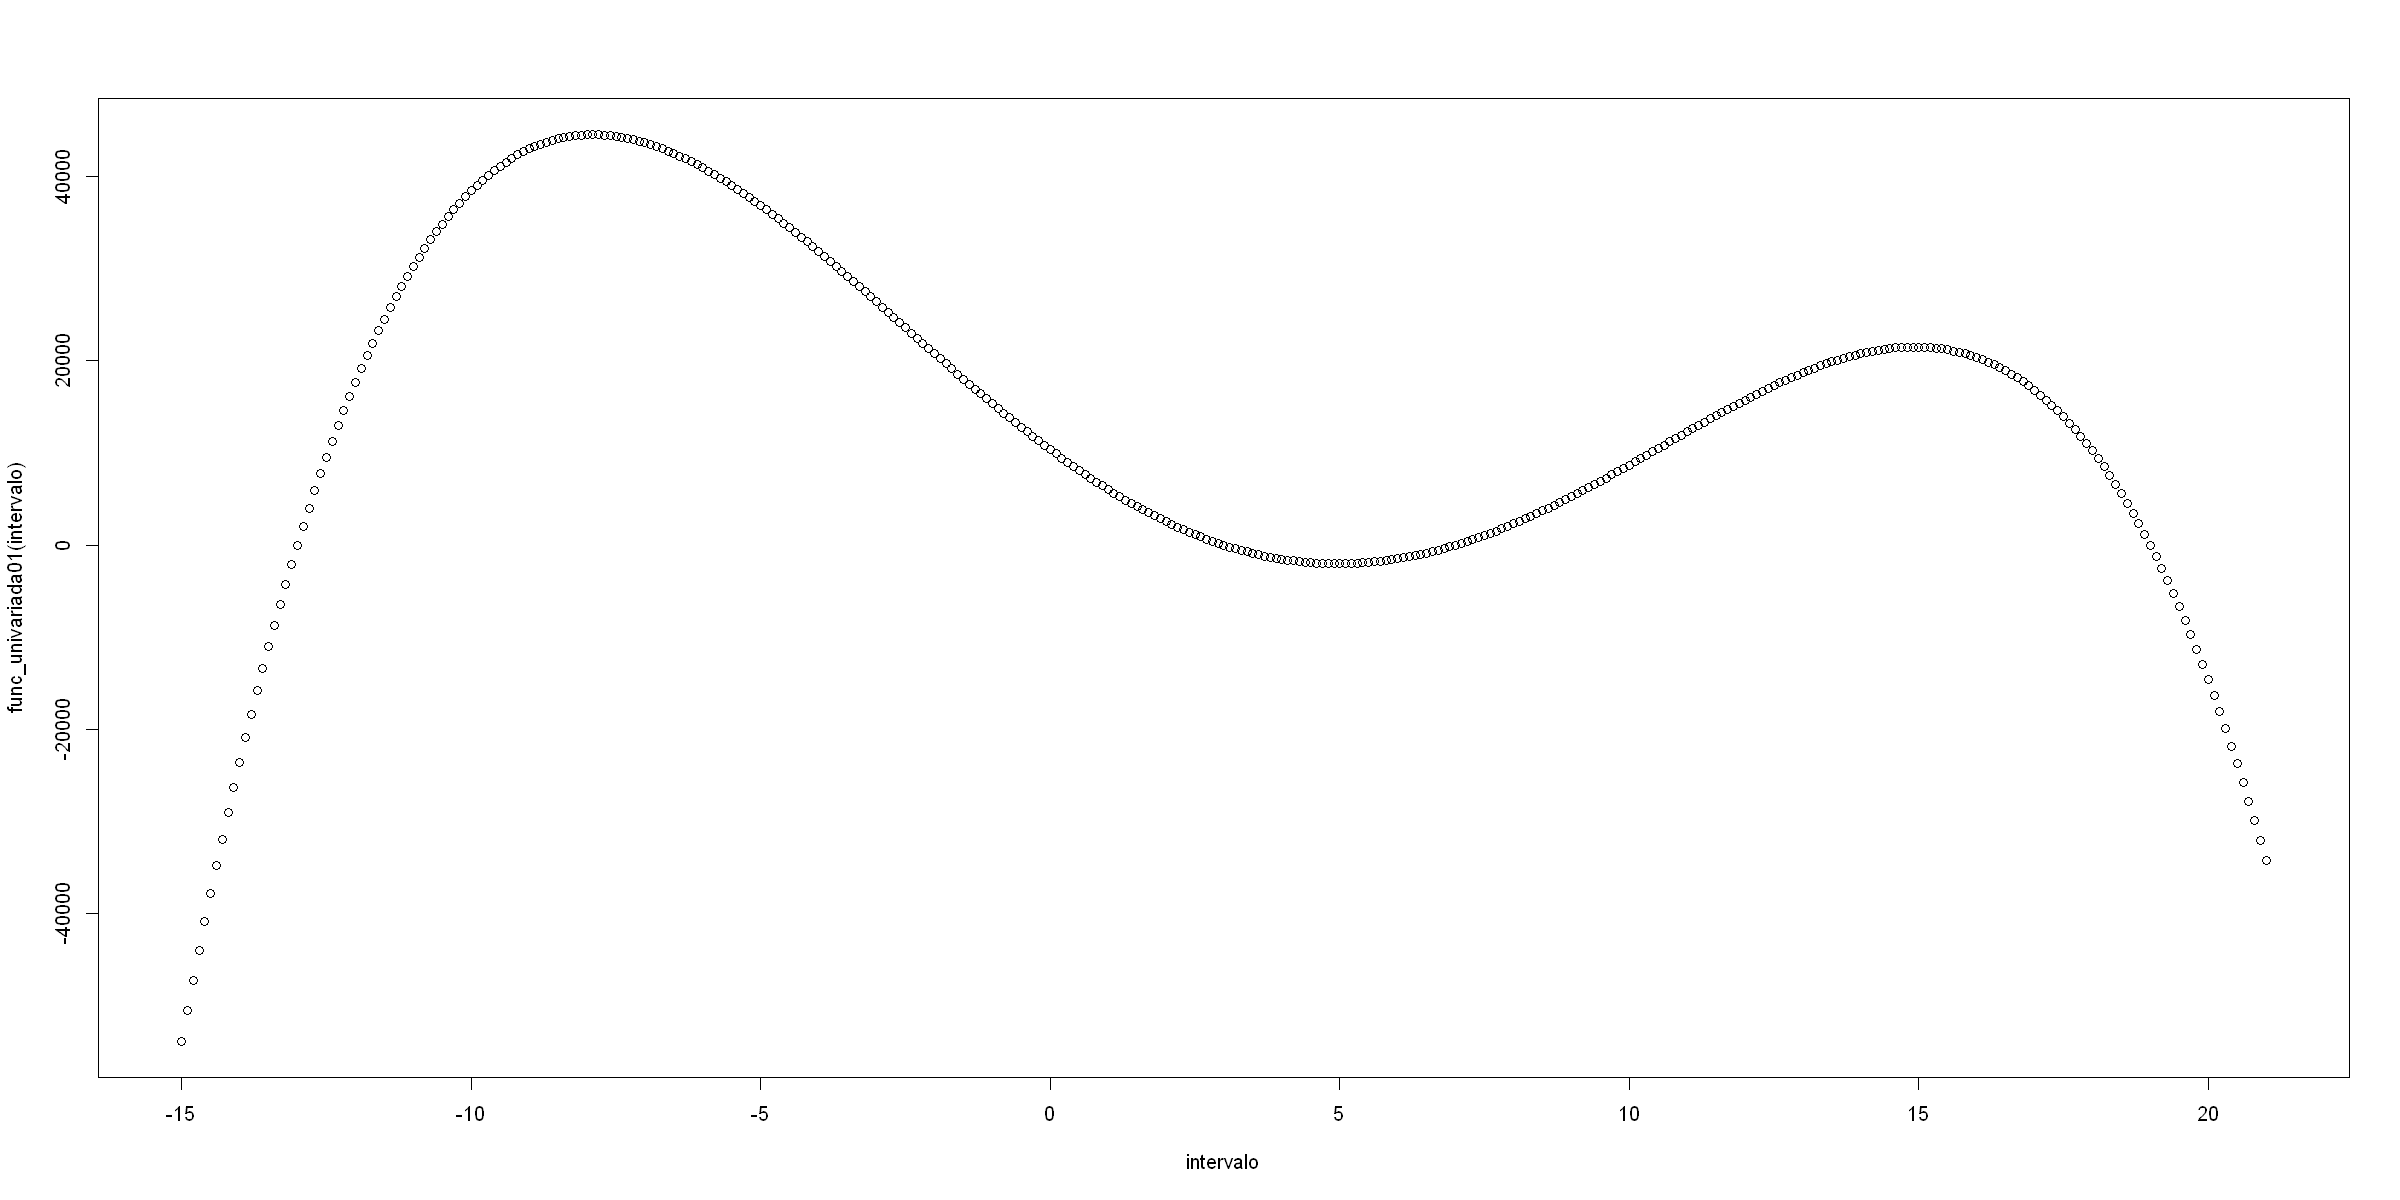

In [7]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [8]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [9]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [10]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [11]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=65.5 : y = -2.66e+07 : 0.0 secs : initdesign

[mbo] 0: x=-12.7 : y = 5.08e+03 : 0.0 secs : initdesign

[mbo] 0: x=-50.5 : y = -1.61e+07 : 0.0 secs : initdesign

[mbo] 0: x=30.9 : y = -6.95e+05 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -70.58324 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       70.583  |proj g|=    0.0035688
At iterate     1  f =       70.583  |proj g|=     0.0035601
At iterate     2  f =        70.58  |proj g|=    0.00093738
At iterate     3  f =        70.58  |proj g|=    0.00046381
At iterate     4  f =        70.58  |proj g|=     0.0001948
At iterate     5  f =        70.58  |proj g|=    8.9811e-05
At iterate     6  f =        70.58  |proj g|=    4.0817e-05
At iterate     7  f =        70.58  |proj g|=    1.8934e-05
At iterate     8  f =        70.58  |proj g|=    8.8153e-06
At iterate     9  f =        70.58 

[mbo] 1: x=-14.8 : y = -4.81e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -86.18619 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       86.186  |proj g|=    0.0016752
At iterate     1  f =       86.186  |proj g|=     0.0016727
At iterate     2  f =       86.185  |proj g|=    8.2848e-05
At iterate     3  f =       86.185  |proj g|=    4.3033e-06
At iterate     4  f =       86.185  |proj g|=    1.1698e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.16978e-08
final function value 86.1852

F = 86.1852
final  value 86.185206 
converg

[mbo] 2: x=13.7 : y = 2.03e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -102.7352 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       102.74  |proj g|=    0.0067245
At iterate     1  f =       102.74  |proj g|=     0.0067215
At iterate     2  f =        102.7  |proj g|=     0.0020188
At iterate     3  f =        102.7  |proj g|=     0.0010983
At iterate     4  f =        102.7  |proj g|=    9.8141e-05
At iterate     5  f =        102.7  |proj g|=    4.2871e-06
At iterate     6  f =        102.7  |proj g|=    1.7726e-08

iterations 6
function evaluations 8
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 3: x=22.6 : y = -7.72e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -117.9238 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       117.92  |proj g|=    0.0015579
At iterate     1  f =       117.92  |proj g|=     0.0015573
At iterate     2  f =       117.92  |proj g|=    0.00019233
At iterate     3  f =       117.92  |proj g|=    2.0263e-05
At iterate     4  f =       117.92  |proj g|=     2.325e-07
At iterate     5  f =       117.92  |proj g|=    2.8518e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.85175e-10
final functio

[mbo] 4: x=1.12 : y = 5.58e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -133.1193 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       133.12  |proj g|=    0.0012599
At iterate     1  f =       133.12  |proj g|=     0.0012596
At iterate     2  f =       133.12  |proj g|=    0.00017295
At iterate     3  f =       133.12  |proj g|=    1.9913e-05
At iterate     4  f =       133.12  |proj g|=    2.7473e-07
At iterate     5  f =       133.12  |proj g|=    4.4411e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.44107e-10
final functio

[mbo] 5: x=-5.44 : y = 3.88e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -147.2516 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       147.25  |proj g|=    2.161e-05
At iterate     1  f =       147.25  |proj g|=    2.1606e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.16064e-05
final function value 147.252

F = 147.252
final  value 147.251588 
converged


[mbo] 6: x=7.69 : y = 1.52e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -161.1552 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       161.16  |proj g|=   0.00022788
At iterate     1  f =       161.16  |proj g|=    0.00022784

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000227844
final function value 161.155

F = 161.155
final  value 161.155189 
converged


[mbo] 7: x=17.7 : y = 1.25e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -174.4788 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       174.48  |proj g|=    0.0015447
At iterate     1  f =       174.48  |proj g|=     0.0015445
At iterate     2  f =       174.47  |proj g|=    0.00022058
At iterate     3  f =       174.47  |proj g|=    3.7337e-05
At iterate     4  f =       174.47  |proj g|=    1.1323e-06
At iterate     5  f =       174.47  |proj g|=    6.0405e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 6.04049e-09
final functio

[mbo] 8: x=-8.74 : y = 4.37e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -187.3429 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       187.34  |proj g|=   0.00016664
At iterate     1  f =       187.34  |proj g|=    0.00016663

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00016663
final function value 187.343

F = 187.343
final  value 187.342919 
converged


[mbo] 9: x=-2.28 : y = 2.24e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -200.0198 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       200.02  |proj g|=   0.00032067
At iterate     1  f =       200.02  |proj g|=    0.00032066

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000320656
final function value 200.02

F = 200.02
final  value 200.019820 
converged


[mbo] 10: x=4.47 : y = -1.89e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -212.6321 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       212.63  |proj g|=   0.00035519
At iterate     1  f =       212.63  |proj g|=    0.00035518

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000355178
final function value 212.632

F = 212.632
final  value 212.632128 
converged


[mbo] 11: x=10.9 : y = 1.18e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -225.0351 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       225.04  |proj g|=   0.00034596
At iterate     1  f =       225.04  |proj g|=    0.00034595

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000345945
final function value 225.035

F = 225.035
final  value 225.035138 
converged


[mbo] 12: x=-7.17 : y = 4.4e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -236.5869 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       236.59  |proj g|=    0.0007579
At iterate     1  f =       236.59  |proj g|=    0.00075787
At iterate     2  f =       236.58  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 236.584

F = 236.584
final  value 236.583719 
converged


[mbo] 13: x=-10.4 : y = 3.55e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -248.2454 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       248.25  |proj g|=    0.0019334
At iterate     1  f =       248.25  |proj g|=     0.0019332
At iterate     2  f =       248.23  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 248.226

F = 248.226
final  value 248.226453 
converged


[mbo] 14: x=15.7 : y = 2.09e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -260.0403 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       260.04  |proj g|=    0.0033833
At iterate     1  f =       260.04  |proj g|=      0.003383
At iterate     2  f =       259.99  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 259.985

F = 259.985
final  value 259.985464 
converged


[mbo] 15: x=-3.98 : y = 3.18e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -271.3408 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       271.34  |proj g|=    0.0033986
At iterate     1  f =       271.34  |proj g|=     0.0033983
At iterate     2  f =       271.31  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 271.314

F = 271.314
final  value 271.314374 
converged


[mbo] 16: x=25.9 : y = -2.33e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -284.2953 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        284.3  |proj g|=    0.0035995
At iterate     1  f =        284.3  |proj g|=     0.0035992
At iterate     2  f =       284.29  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 284.293

F = 284.293
final  value 284.292750 
converged


[mbo] 17: x=19.8 : y = -1.06e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -296.2241 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       296.22  |proj g|=    0.0056658
At iterate     1  f =       296.22  |proj g|=     0.0056653
At iterate     2  f =       296.14  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 296.143

F = 296.143
final  value 296.143306 
converged


[mbo] 18: x=-7.95 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -306.4332 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       306.43  |proj g|=    0.0051326
At iterate     1  f =       306.43  |proj g|=     0.0051322
At iterate     2  f =       306.43  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 306.43

F = 306.43
final  value 306.429712 
converged


[mbo] 19: x=-6.37 : y = 4.21e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -316.7614 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       316.76  |proj g|=    0.0061753
At iterate     1  f =       316.76  |proj g|=     0.0061747
At iterate     2  f =       316.74  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 316.739

F = 316.739
final  value 316.738762 
converged


[mbo] 20: x=-9.5 : y = 4.11e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -327.0316 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       327.03  |proj g|=    0.0070006
At iterate     1  f =       327.03  |proj g|=     0.0069999
At iterate     2  f =          327  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 327.003

F = 327.003
final  value 327.003410 
converged


[mbo] 21: x=-0.661 : y = 1.36e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -338.8779 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       338.88  |proj g|=       0.0155
At iterate     1  f =       338.88  |proj g|=      0.015496
At iterate     2  f =        338.3  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 338.302

F = 338.302
final  value 338.302391 
converged


[mbo] 22: x=12.3 : y = 1.68e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -349.3774 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       349.38  |proj g|=    0.0083692
At iterate     1  f =       349.38  |proj g|=     0.0083683
At iterate     2  f =       349.36  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 349.359

F = 349.359
final  value 349.359087 
converged


[mbo] 23: x=-7.58 : y = 4.44e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -358.5379 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       358.54  |proj g|=    0.0096588
At iterate     1  f =       358.54  |proj g|=     0.0096576
At iterate     2  f =       358.48  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 358.478

F = 358.478
final  value 358.477651 
converged


[mbo] 24: x=-8.34 : y = 4.43e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -367.7567 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       367.76  |proj g|=     0.012488
At iterate     1  f =       367.76  |proj g|=      0.012486
At iterate     2  f =       367.53  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 367.531

F = 367.531
final  value 367.531448 
converged


[mbo] 25: x=9.3 : y = 6.25e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  231.9324 
  - best initial criterion value(s) :  -378.8301 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       378.83  |proj g|=     0.012571
At iterate     1  f =       378.83  |proj g|=      0.012569
At iterate     2  f =       378.65  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 378.654

F = 378.654
final  value 378.654321 
converged


In [13]:
tb_resultados  <- as.data.table( run$opt.path )

In [14]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
65.4526885,-26607514.697,0,NA,NA,0.02,NA,NA,NA,initdesign,NA,NA,NA
-12.7427891,5075.218,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-50.5135145,-16051675.669,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
30.8874462,-695084.071,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-14.8281331,-48132.486,1,NA,NA,0.00,-1814146.7021,NA,0.06,infill_ei,0.14,8327770.493,-3636606.757
13.7136947,20315.011,2,NA,NA,0.00,-2821252.8806,NA,0.03,infill_ei,0.14,7031805.994,36953.886
22.5637890,-77182.404,3,NA,NA,0.00,-1029739.0999,NA,0.01,infill_ei,0.16,1783909.727,585575.739
1.1204592,5579.950,4,NA,NA,0.00,-737513.8754,NA,0.01,infill_ei,0.14,1796685.910,61419.667
-5.4388502,38793.782,5,NA,NA,0.00,-236761.1805,NA,0.01,infill_ei,0.16,599140.535,15778.687


In [15]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.951517,44558.82,18,NA,NA,0,-4981.38,NA,0.01,infill_ei,0.22,11839.16,44486.19


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?